## CS512 - Segmentation and classification of skin lesions
### Contains:
#### 1. VGG16
#### 2. ResNet50
#### 3. Ensemble : VGG16+Resnet50
#### 4. Unet
#### 5. Predict Results with Segmenated and HAM10000 images on pre-trained classifier models. 
#### --------------------------------------
#### --------------------------------------
### Authors:
#### Sourav Yadav - A20450418
#### Akshay R - A20442409

### Importing Libraries


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
import random
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, MaxPool2D, UpSampling2D, Input, Reshape

from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Plotting Accuracy and Loss

In [2]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Importing Images

In [3]:
base_skin_dir = os.path.join('..', 'input/skin-cancer-mnist-ham10000')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
print(skin_df.columns)

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx'],
      dtype='object')


In [6]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2


In [7]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


In [19]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((128,96))))

## Visualizing Images

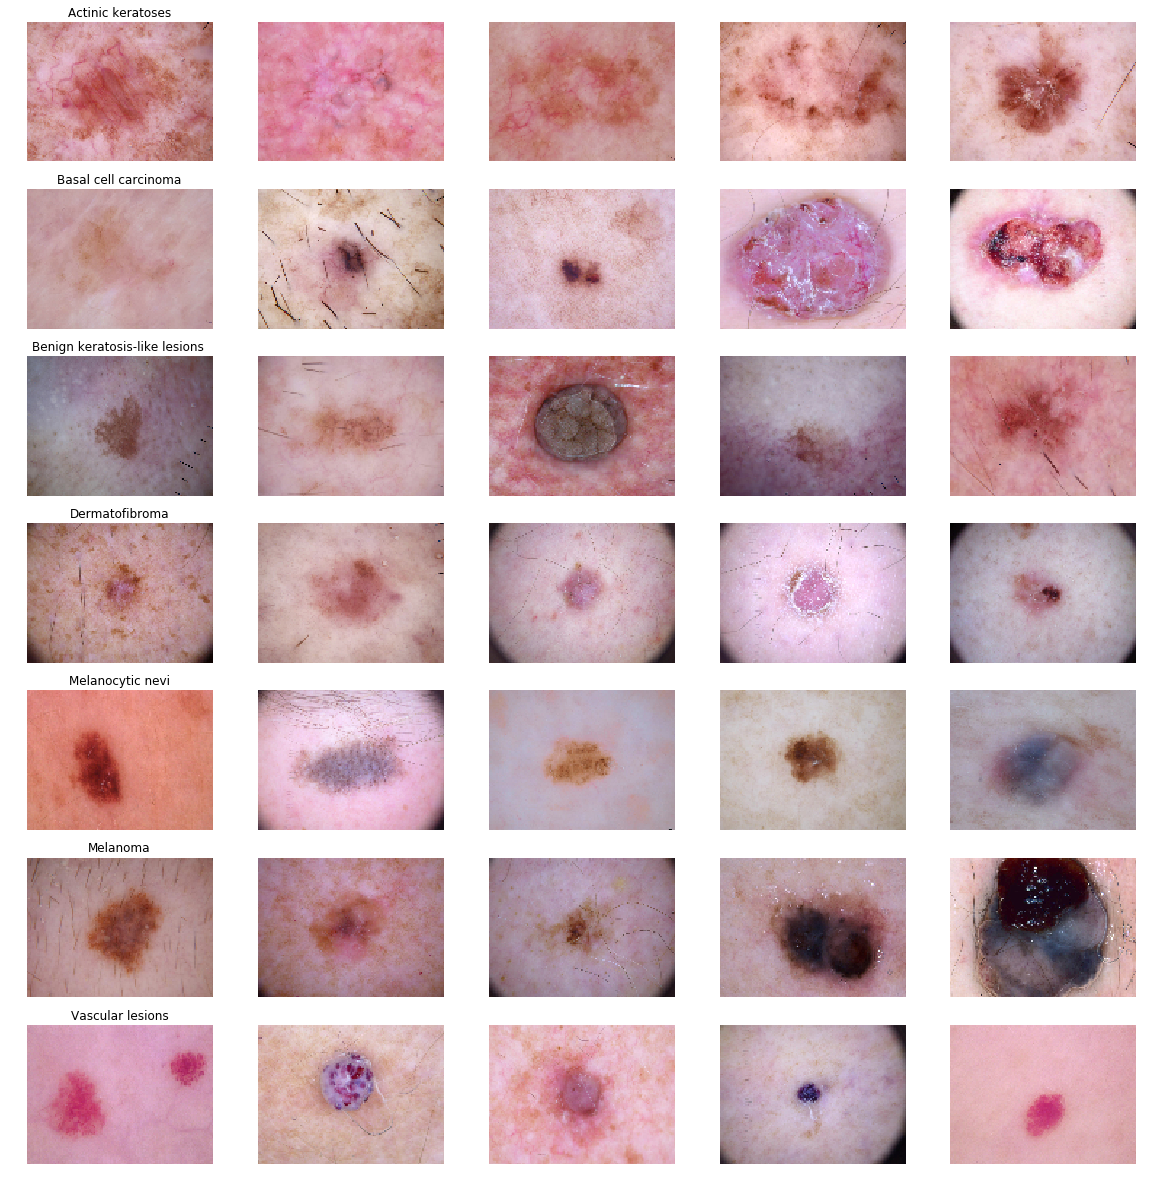

In [20]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [21]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(96, 128, 3)    10015
Name: image, dtype: int64

In [22]:
features = skin_df.drop(columns=['cell_type_idx'],axis=1)
target = skin_df['cell_type_idx']

## Splitting data into Train and Test

In [23]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.10,random_state=1234)

In [24]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [25]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [26]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [27]:
x_train = x_train.reshape(x_train.shape[0], *(96, 128, 3))
x_test = x_test.reshape(x_test.shape[0], *(96, 128, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(96, 128, 3))

In [28]:
print(np.bincount(skin_df['cell_type_idx']))

[ 327  514 1099  115 6705 1113  142]


## Defining our VGG16 Model

In [29]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

from keras.applications.vgg16 import VGG16


def vgg16(epochs, batch_size, classes, model_input):
    # create the base pre-trained model
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=model_input)
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    # add Dropout layer to reduce overfitting
    x = Dropout(0.2)(x)
    # and a logistic layer
    predictions = Dense(classes, activation='softmax', use_bias=True)(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False

    sgd = optimizers.SGD(lr=0.01, clipvalue=0.5)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=3, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)

    # train 
    history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                                  class_weight=class_weights,
                                  epochs = epochs, validation_data = (x_validate,y_validate),
                                  verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                                  callbacks=callbacks)

    return model, history

## Defining ResNet50 Model

In [30]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

from keras.applications.resnet50 import ResNet50


def resnet50(epochs, batch_size, classes, model_input):
    # create the base pre-trained model
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=model_input)
  
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(classes, activation='softmax', use_bias=True)(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=3, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
    
    # train 
    history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                                  class_weight=class_weights,
                                  epochs = epochs, validation_data = (x_validate,y_validate),
                                  verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                                  callbacks=callbacks)

    return model, history

In [31]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [32]:
 optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [33]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

callbacks = [learning_rate_reduction, checkpoint, early]

## Defining Data Generator

In [34]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [35]:
total = 0
class_weights = []
for i in skin_df['cell_type'].value_counts():
    total += i
class_weights = [1 - (i/total) for i in skin_df['cell_type'].value_counts()]

## Traning VGG16 and ResNet50 Model

In [36]:
epochs = 100
batch_size = 10
classes = 7

model_input = Input(shape=(96, 128, 3))
vgg16_model, history = vgg16(epochs, batch_size, classes, model_input)
resnet50_model, resnet50_history = resnet50(epochs, batch_size, classes, model_input)

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/100
811/811 [==============================] - 34s 42ms/step - loss: 0.9833 - accuracy: 0.6762 - val_loss: 0.8602 - val_accuracy: 0.7173
Epoch 2/100
  4/811 [..............................] - ETA: 28s - loss: 0.7888 - accuracy: 0.7000

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


811/811 [==============================] - 29s 36ms/step - loss: 0.8887 - accuracy: 0.6887 - val_loss: 0.8177 - val_accuracy: 0.7073
Epoch 3/100
811/811 [==============================] - 30s 37ms/step - loss: 0.8483 - accuracy: 0.6952 - val_loss: 0.7827 - val_accuracy: 0.7262
Epoch 4/100
811/811 [==============================] - 29s 36ms/step - loss: 0.8196 - accuracy: 0.7015 - val_loss: 0.7623 - val_accuracy: 0.7151
Epoch 5/100
811/811 [==============================] - 30s 37ms/step - loss: 0.8042 - accuracy: 0.7052 - val_loss: 0.7720 - val_accuracy: 0.7084
Epoch 6/100
811/811 [==============================] - 29s 36ms/step - loss: 0.7851 - accuracy: 0.7192 - val_loss: 0.7599 - val_accuracy: 0.7195

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 7/100
811/811 [==============================] - 30s 37ms/step - loss: 0.7564 - accuracy: 0.7253 - val_loss: 0.7735 - val_accuracy: 0.7206
Epoch 8/100
811/811 [==============================] - 29s 36m

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
Epoch 1/100
811/811 [==============================] - 123s 152ms/step - loss: 1.9641 - accuracy: 0.6557 - val_loss: 0.9166 - val_accuracy: 0.6796
Epoch 2/100
  1/811 [..............................] - ETA: 1:23 - loss: 0.3867 - accuracy: 0.9000

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


811/811 [==============================] - 100s 123ms/step - loss: 0.9246 - accuracy: 0.6826 - val_loss: 0.8067 - val_accuracy: 0.7095
Epoch 3/100
811/811 [==============================] - 99s 122ms/step - loss: 0.8473 - accuracy: 0.7083 - val_loss: 0.7340 - val_accuracy: 0.7273
Epoch 4/100
811/811 [==============================] - 98s 120ms/step - loss: 0.8066 - accuracy: 0.7178 - val_loss: 0.6776 - val_accuracy: 0.7339
Epoch 5/100
811/811 [==============================] - 98s 121ms/step - loss: 0.7726 - accuracy: 0.7263 - val_loss: 0.6926 - val_accuracy: 0.7395
Epoch 6/100
811/811 [==============================] - 98s 121ms/step - loss: 0.7761 - accuracy: 0.7272 - val_loss: 0.6630 - val_accuracy: 0.7450
Epoch 7/100
811/811 [==============================] - 96s 118ms/step - loss: 0.8384 - accuracy: 0.7174 - val_loss: 0.7683 - val_accuracy: 0.7217
Epoch 8/100
811/811 [==============================] - 98s 121ms/step - loss: 0.9108 - accuracy: 0.6940 - val_loss: 0.7687 - val_accura

Epoch 54/100
811/811 [==============================] - 104s 128ms/step - loss: 0.4452 - accuracy: 0.8306 - val_loss: 0.8276 - val_accuracy: 0.7727
Epoch 55/100
811/811 [==============================] - 104s 128ms/step - loss: 0.4351 - accuracy: 0.8383 - val_loss: 0.7739 - val_accuracy: 0.7761
Epoch 56/100
811/811 [==============================] - 103s 127ms/step - loss: 0.4241 - accuracy: 0.8358 - val_loss: 0.8185 - val_accuracy: 0.7794
Epoch 57/100
811/811 [==============================] - 104s 128ms/step - loss: 0.4282 - accuracy: 0.8406 - val_loss: 0.8262 - val_accuracy: 0.7827
Epoch 58/100
811/811 [==============================] - 104s 129ms/step - loss: 0.4222 - accuracy: 0.8401 - val_loss: 0.7164 - val_accuracy: 0.7827
Epoch 59/100
811/811 [==============================] - 103s 127ms/step - loss: 0.4315 - accuracy: 0.8363 - val_loss: 0.7563 - val_accuracy: 0.7761
Epoch 60/100
811/811 [==============================] - 102s 126ms/step - loss: 0.4298 - accuracy: 0.8399 - val_

In [38]:
# the first 249 layers and unfreeze the rest:
for layer in vgg16_model.layers[:-2]:
   layer.trainable = False
for layer in vgg16_model.layers[-2:]:
   layer.trainable = True

In [39]:
# we use SGD with a low learning rate
from keras.optimizers import SGD
vgg16_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
vgg16_model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size))

Epoch 1/1
812/812 [==============================] - 27s 33ms/step - loss: 0.6849 - accuracy: 0.7491


## Checking the performance of VGG16 on test and validation data

In [41]:
loss, accuracy = vgg16_model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = vgg16_model.evaluate(x_validate, y_validate, verbose=1)
print("VGG16")
print("Validation: val_accuracy = %f  -  val_loss = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  -  loss = %f" % (accuracy, loss))

902/902 [==============================] - 1s 971us/step
VGG16
Validation: val_accuracy = 0.747228  -  val_loss = 0.686720
Test: accuracy = 0.741517  -  loss = 0.694497


## Checking the performance of ResNet50 on test and validation data

In [42]:
loss, accuracy = resnet50_model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = resnet50_model.evaluate(x_validate, y_validate, verbose=1)
print("ResNet50")
print("Validation: val_accuracy = %f  -  val_loss = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  -  loss = %f" % (accuracy, loss))

902/902 [==============================] - 1s 1ms/step
ResNet50
Validation: val_accuracy = 0.786031  -  val_loss = 1.139440
Test: accuracy = 0.789421  -  loss = 0.717045


## Plotting Loss and Accuracy Graph of VGG16 and ResNet50

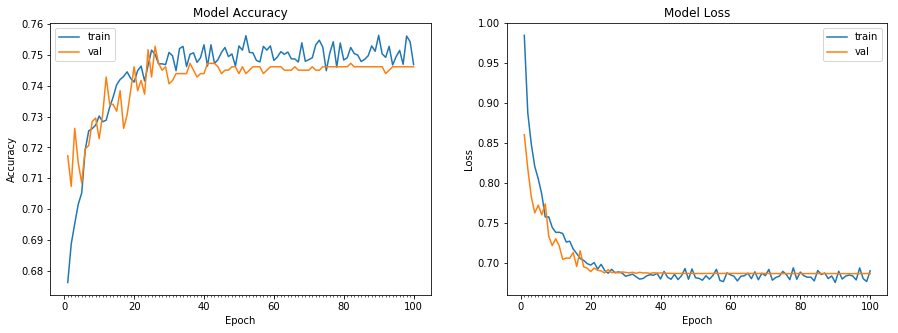

In [43]:
#VGG16 Results
plot_model_history(history)

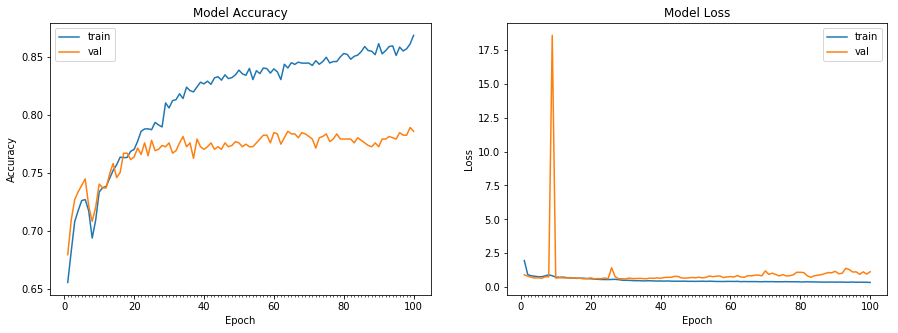

In [44]:
#ResNet50 results
plot_model_history(resnet50_history)

### Defining Ensemble Model : VGG16+ResNet50

In [45]:
#Ensemble Model : Vgg16+Resnet50
from keras.layers import Average

ensembled_models = [vgg16_model, resnet50_model]
outputs = Average()([m.outputs[0] for m in ensembled_models])
ensemble_model = Model(model_input, outputs, name='ensemble')
sgd = optimizers.SGD(lr=0.01, clipvalue=0.5)
ensemble_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 128, 3)   0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 64, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

## Peformance of Ensemble Model

In [46]:
loss, accuracy = ensemble_model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = ensemble_model.evaluate(x_validate, y_validate, verbose=1)
print("Ensemble")
print("Validation: val_accuracy = %f  -  val_loss = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  -  loss = %f" % (accuracy, loss))

902/902 [==============================] - 2s 2ms/step
Ensemble
Validation: val_accuracy = 0.790466  -  val_loss = 0.572163
Test: accuracy = 0.793413  -  loss = 0.577973


## Confusion Matrix

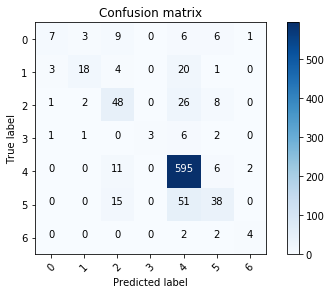

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = ensemble_model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

Text(0, 0.5, 'Fraction classified incorrectly')

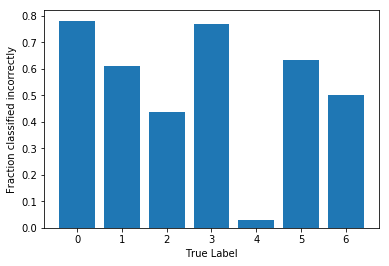

In [48]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

## Saving Weights

In [49]:
vgg16_model.save('vgg16_weights')
resnet50_model.save('resnet50_weights')
ensemble_model.save('ensemble_classifier')

## Defining Unet Model for Segmenation

In [50]:
def unet():
    input_shape = (96, 128, 3)
    img_input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)

    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    
    pred = Reshape((96, 128))(x)
    model = Model(inputs=img_input, outputs=pred)
    model.load_weights('unet_100_epoch.h5')
    
    return model

unet_model = unet()

In [51]:
def enhance(img):
    sub = (unet_model.predict(img.reshape(1,96,128,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

In [52]:
import cv2

def applyMask(img):
    mask = np.array(enhance(img).reshape(96, 128), dtype=np.uint8)
    
    res = cv2.bitwise_and(img,img,mask = mask)
    
    return res

In [53]:
#Applying masks
random_sample_df = skin_df.sample(n=5)
print(random_sample_df['cell_type'].value_counts())

img_list = [img for img in random_sample_df['image']]

seg_img_list = [applyMask(img) for img in img_list]

Melanocytic nevi    5
Name: cell_type, dtype: int64


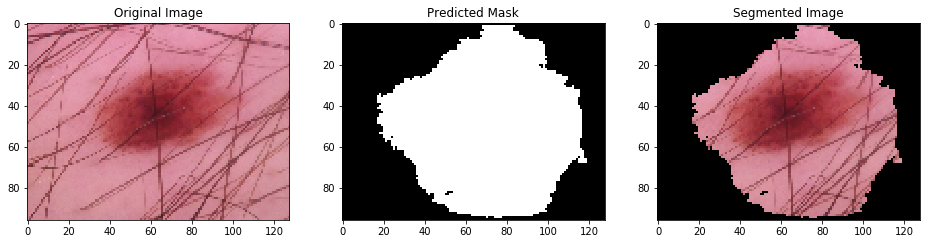

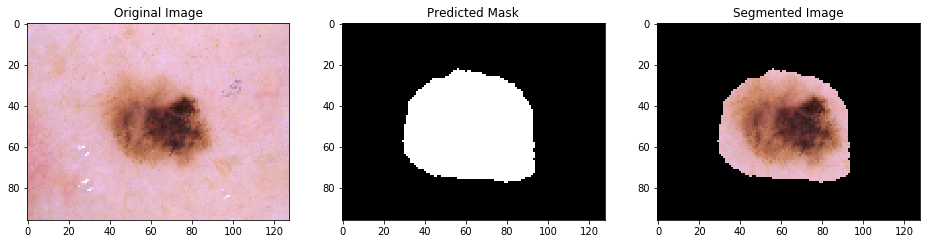

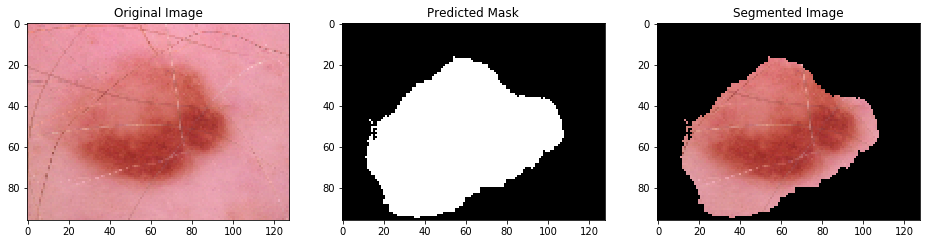

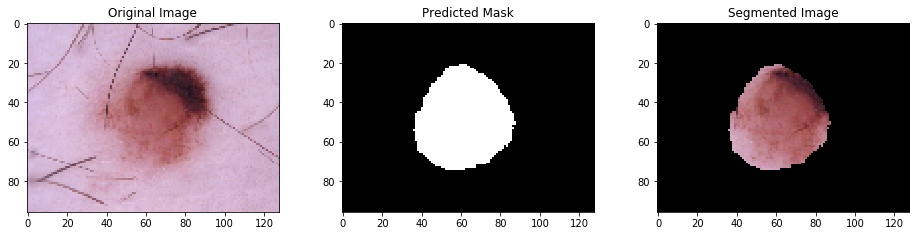

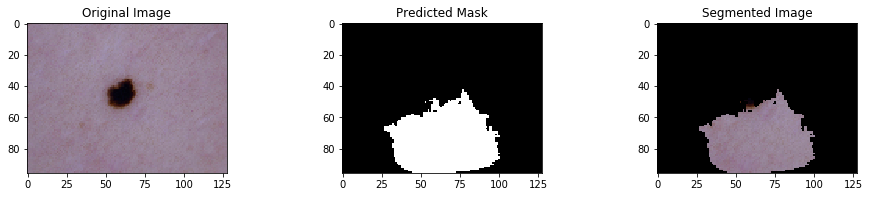

In [54]:
def show_comparison(img_list):
    for i in range(len(img_list)):
        plt.figure(figsize=(16,16))
        plt.subplot(i+1,3,1)
        plt.imshow(img_list[i])
        plt.title('Original Image')
        plt.subplot(i+1,3,2)
        plt.imshow(enhance(img_list[i]).reshape(96, 128), plt.cm.binary_r)
        plt.title('Predicted Mask')
        plt.subplot(i+1,3,3)
        plt.imshow(applyMask(img_list[i]), plt.cm.binary_r)
        plt.title('Segmented Image')
    
show_comparison(img_list)

## Predict Results with Segmenated and Normal RGB images on pre-trained models

In [57]:
#Ensemble Prediction
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from keras.layers import Average


# VGG16 Predictions - Unaltered
validation_batch = np.stack([vgg16_preprocess_input(img) for img in img_list])
pred = vgg16_model.predict(validation_batch)

# VGG16 Predictions - Segmented
segmented_validation_batch = np.stack([vgg16_preprocess_input(img) for img in seg_img_list])
vgg16_seg_pred = vgg16_model.predict(segmented_validation_batch)

# ResNet50 Predictions - Unaltered
resnet_validation_batch = np.stack([resnet50_preprocess_input(img) for img in img_list])
res_pred = resnet50_model.predict(resnet_validation_batch)

# ResNet50 Predictions - Segmented
resnet_segmented_validation_batch = np.stack([resnet50_preprocess_input(img) for img in seg_img_list])
res_seg_pred = resnet50_model.predict(resnet_segmented_validation_batch)

# Ensemble Predictions
e_validation_batch = np.stack([img for img in img_list])
e_seg_validation_batch = np.stack([img for img in img_list])
e_preds = ensemble_model.predict(e_validation_batch)
e_seg_pred = ensemble_model.predict(e_seg_validation_batch)
for p in e_preds: np.random.shuffle(p)
for p in e_seg_pred: np.random.shuffle(p)
print(e_preds)

[array([0.000000e+00, 4.238172e-32, 6.100000e-01, 0.000000e+00,
       0.000000e+00, 7.134404e-34, 0.000000e+00], dtype=float32), array([9.3141595e-21, 6.9000000e-01, 0.0000000e+00, 8.2300202e-33,
       0.0000000e+00, 9.5879935e-37, 4.6534091e-29], dtype=float32), array([5.6000000e-01, 1.4448976e-27, 7.7363914e-30, 7.8184083e-19,
       2.2023069e-27, 2.1873555e-25, 2.9159311e-30], dtype=float32), array([5.93767331e-28, 1.39806405e-30, 1.43559099e-32, 9.63638822e-30,
       6.20000005e-01, 1.40135655e-25, 6.42642381e-37], dtype=float32), array([2.5259730e-14, 1.0670996e-01, 6.2328947e-01, 5.5928007e-07,
       7.6843852e-14, 1.9140795e-14, 3.5407086e-09], dtype=float32)]


## Plotting Images from Ensembled Results

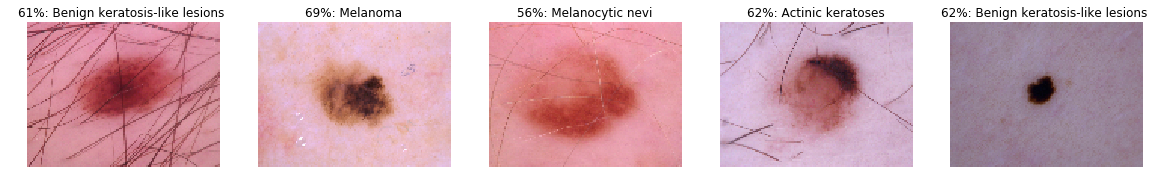

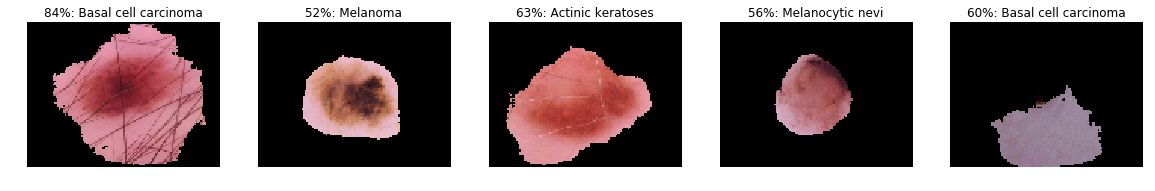

In [58]:
#Ensemle Output
import numpy as np


classes = [
    'Melanocytic nevi',
    'Melanoma',
    'Benign keratosis-like lesions ',
    'Basal cell carcinoma',
    'Actinic keratoses',
    'Vascular lesions',
    'Dermatofibroma'
]

# Unaltered
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    p_idx = np.argmax(e_preds[i])
    title = "{:.0f}%: {:}".format(100*e_preds[i][p_idx], classes[p_idx])
    ax.set_title(title)
    ax.imshow(img)

# Segmented
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(seg_img_list):
    ax = axs[i]
    ax.axis('off')
    p_idx = np.argmax(e_seg_pred[i])
    title = "{:.0f}%: {:}".format(100*a[i][p_idx], classes[p_idx])
    ax.set_title(title)
    ax.imshow(img)
    